# Automatically Extracting Bricks with SAM

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. A high RAM configuration is recomended for larger images

In [1]:
using_colab = True

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-qkm9ras2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-qkm9ras2
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=9c43767d6e2eb9b0ed186a74d9a866f30297e35eba47c29d7abd7fc34f7ce2cf
  Stored in directory: /tmp/pip-ephem-wheel-cache-t1srkf8z/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-04-24 21:18:35--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

## Set-up

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

## Mask Generation Without Custom Params

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

To generate masks, just run `generate` on an image.

In [47]:
image = cv2.imread('images/crop_3.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [48]:
print(len(masks))
print(masks[0].keys())

179
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

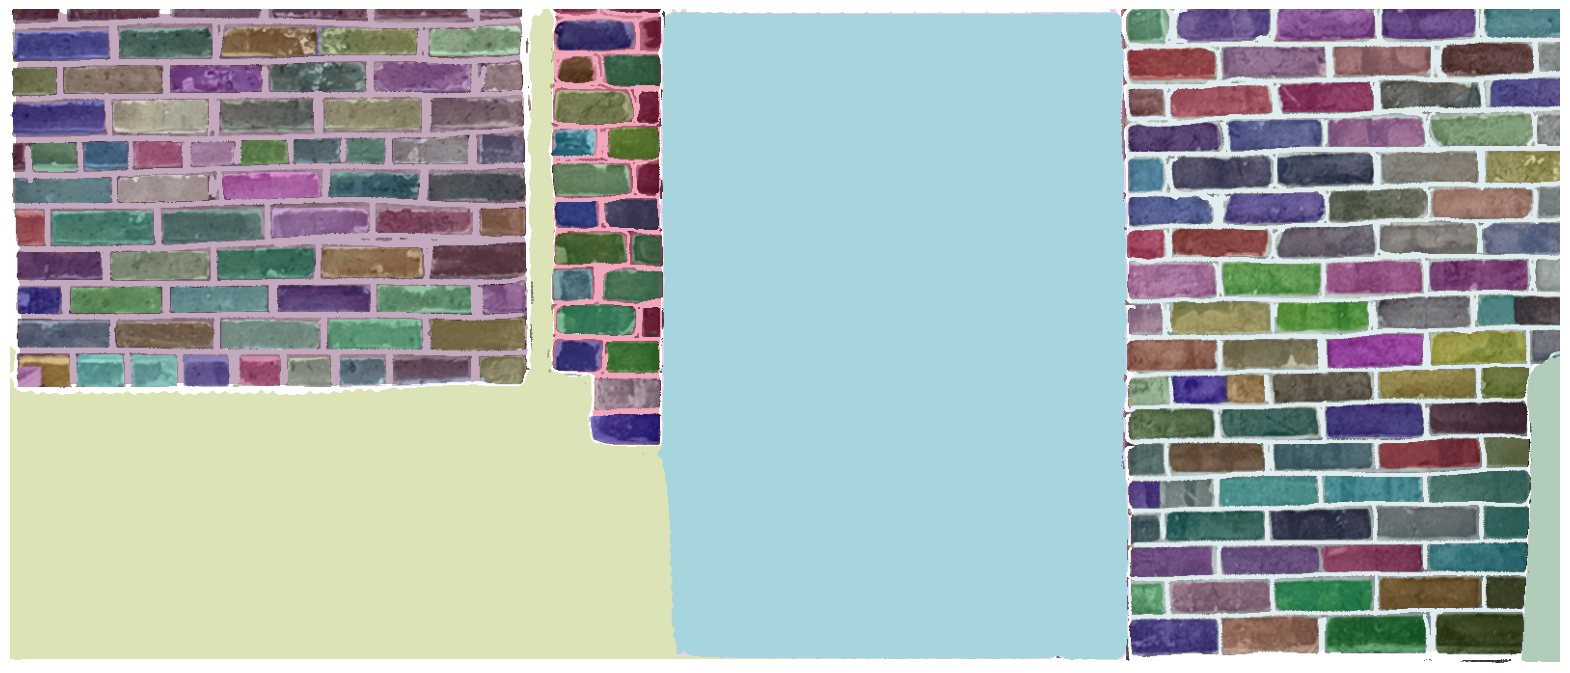

In [49]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Automatic Mask Generation With Custom Params

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [44]:
import cv2
import os

def crop_image_to_sections(image_path, crop_width=1500, crop_height=500, output_folder='/content/images'):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image could not be loaded.")
        return

    # Get image dimensions
    img_height, img_width, _ = image.shape
    print(f"Original image dimensions: {img_width}x{img_height}")

    # Ensure the output directory exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Calculate number of crops along width and height
    num_crops_width = max(1, img_width // crop_width)
    num_crops_height = max(1, img_height // crop_height)

    # Calculate actual sizes of each crop (to handle non-perfect fits)
    actual_crop_width = img_width // num_crops_width
    actual_crop_height = img_height // num_crops_height

    # Crop the image
    crop_number = 0
    for i in range(num_crops_height):
        for j in range(num_crops_width):
            # Define crop dimensions
            start_x = j * actual_crop_width
            start_y = i * actual_crop_height
            crop_img = image[start_y:start_y + actual_crop_height, start_x:start_x + actual_crop_width]

            # Save cropped image
            crop_filename = f'crop_{crop_number}.png'
            cv2.imwrite(os.path.join(output_folder, crop_filename), crop_img)
            print(f"Cropped image saved as {crop_filename} with dimensions {actual_crop_width}x{actual_crop_height}")
            crop_number += 1

    print("All sections have been cropped and saved.")

# Example usage
image_path = 'original.png'  # Replace this with the path to your image
crop_image_to_sections(image_path)

Original image dimensions: 4823x1356
Cropped image saved as crop_0.png with dimensions 1607x678
Cropped image saved as crop_1.png with dimensions 1607x678
Cropped image saved as crop_2.png with dimensions 1607x678
Cropped image saved as crop_3.png with dimensions 1607x678
Cropped image saved as crop_4.png with dimensions 1607x678
Cropped image saved as crop_5.png with dimensions 1607x678
All sections have been cropped and saved.


In [45]:
import cv2
import os
import shutil
import numpy as np
from zipfile import ZipFile

# Path to the directory containing images
image_dir = 'images'

# Main directory for cropped images
save_dir = 'cropped_masks'

# Zip file for the cropped images
zip_filename = 'cropped_masks.zip'

# Ensure directories are cleaned up at the beginning of the script
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)  # Removes the directory along with all its contents

# If the zip file exists, remove it
if os.path.exists(zip_filename):
    os.remove(zip_filename)

# Subdirectories for different classifications
rejected_dir = os.path.join(save_dir, 'rejected')
nominal_dir = os.path.join(save_dir, 'nominal')

# Recreate necessary directories
os.makedirs(rejected_dir, exist_ok=True)
os.makedirs(nominal_dir, exist_ok=True)

# Initialize mask generator
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=.95,
    stability_score_thresh=.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=20  # Requires open-cv to run post-processing
)

# Sensitivity of outlier detection, measured in standard deviations
outlier_sensitivity = 5  # Can be adjusted to control the range of outlier detection

# Process each image in the directory
for image_file in os.listdir(image_dir):
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load {image_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        print(f"Processing {image_file}...")
        masks = mask_generator_2.generate(image)
        print(f"Generated {len(masks)} masks for {image_file}.")

        areas = []

        for index, mask in enumerate(masks):
            x, y, w, h = mask['bbox']
            crop_img = image[y:y+h, x:x+w]
            aspect_ratio = h / w
            area = w * h
            areas.append((area, index, crop_img, aspect_ratio))
            print(f"Processed mask {index+1}/{len(masks)} for {image_file}.")

        areas_np = np.array([area[0] for area in areas])
        avg_area = np.mean(areas_np)
        std_area = np.std(areas_np)

        outlier_threshold_low = avg_area - outlier_sensitivity * std_area
        outlier_threshold_high = avg_area + outlier_sensitivity * std_area

        for area, index, crop_img, aspect_ratio in areas:
            target_dir = nominal_dir if aspect_ratio <= 1 and (area >= outlier_threshold_low and area <= outlier_threshold_high) else rejected_dir
            cv2.imwrite(os.path.join(target_dir, f'crop_{image_file}_{index}.png'), crop_img)
            print(f"Saved cropped image {index+1} of {image_file} in {'rejected' if target_dir == rejected_dir else 'nominal'} directory.")

# Zip the entire cropped_masks directory including all subdirectories
with ZipFile(zip_filename, 'w') as zipf:
    for root, dirs, files in os.walk(save_dir):
        for file in files:
            file_path = os.path.join(root, file)
            relative_path = os.path.relpath(file_path, save_dir)
            zipf.write(file_path, relative_path)
            print(f"Added {relative_path} to zip.")

print("All images and their cropped categories have been processed and zipped.")


Processing crop_1.png...
Generated 348 masks for crop_1.png.
Processed mask 1/348 for crop_1.png.
Processed mask 2/348 for crop_1.png.
Processed mask 3/348 for crop_1.png.
Processed mask 4/348 for crop_1.png.
Processed mask 5/348 for crop_1.png.
Processed mask 6/348 for crop_1.png.
Processed mask 7/348 for crop_1.png.
Processed mask 8/348 for crop_1.png.
Processed mask 9/348 for crop_1.png.
Processed mask 10/348 for crop_1.png.
Processed mask 11/348 for crop_1.png.
Processed mask 12/348 for crop_1.png.
Processed mask 13/348 for crop_1.png.
Processed mask 14/348 for crop_1.png.
Processed mask 15/348 for crop_1.png.
Processed mask 16/348 for crop_1.png.
Processed mask 17/348 for crop_1.png.
Processed mask 18/348 for crop_1.png.
Processed mask 19/348 for crop_1.png.
Processed mask 20/348 for crop_1.png.
Processed mask 21/348 for crop_1.png.
Processed mask 22/348 for crop_1.png.
Processed mask 23/348 for crop_1.png.
Processed mask 24/348 for crop_1.png.
Processed mask 25/348 for crop_1.png

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

In [39]:
import cv2
import os
import shutil
from zipfile import ZipFile

# Main directory for cropped images
save_dir = 'cropped_masks'

# Zip the entire cropped_masks directory including all subdirectories
zip_filename = 'cropped_masks.zip'
with ZipFile(zip_filename, 'w') as zipf:
    for root, dirs, files in os.walk(save_dir):
        for file in files:
            file_path = os.path.join(root, file)
            relative_path = os.path.relpath(file_path, save_dir)
            zipf.write(file_path, relative_path)

print(f"All cropped images and their categories have been zipped in {zip_filename}.")


All cropped images and their categories have been saved and zipped in cropped_masks.zip.
